<a href="https://colab.research.google.com/github/Al95200/machine-translation/blob/master/traducteur_anglais_francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alain/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [ ]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode = 'rt',encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [ ]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
with open("small_vocab_fr.txt") as f1, open("small_vocab_en.txt") as f2:
       line_file1 = f1.readlines()
       line_file2 = f2.readlines()
       print(len(line_file1), len(line_file2))

137860 137860


In [ ]:
temp = []
fr_eng = []
for fr, en in zip(line_file1, line_file2):
    temp.append(en)
    temp.append(fr)
    fr_eng.append(temp)
    temp = []

In [ ]:
fr_eng = array(fr_eng)
fr_eng = fr_eng[:50000,:]

In [ ]:
fr_eng

array([['new jersey is sometimes quiet during autumn , and it is snowy in april .\n',
        "new jersey est parfois calme pendant l' automne , et il est neigeux en avril .\n"],
       ['the united states is usually chilly during july , and it is usually freezing in november .\n',
        'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .\n'],
       ['california is usually quiet during march , and it is usually hot in june .\n',
        'california est généralement calme en mars , et il est généralement chaud en juin .\n'],
       ...,
       ['china is usually warm during september , and it is usually nice in january .\n',
        'chine est habituellement chaud en septembre , et il est généralement agréable en janvier .\n'],
       ['india is usually freezing during december , but it is never beautiful in spring .\n',
        "l' inde est le gel habituellement en décembre , mais il est jamais belle au printemps .\n"],
       ['she wanted to 

In [ ]:
# Remove punctuation
fr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,0]]
fr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,1]]

fr_eng

array([['new jersey is sometimes quiet during autumn  and it is snowy in april \n',
        'new jersey est parfois calme pendant l automne  et il est neigeux en avril \n'],
       ['the united states is usually chilly during july  and it is usually freezing in november \n',
        'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre \n'],
       ['california is usually quiet during march  and it is usually hot in june \n',
        'california est généralement calme en mars  et il est généralement chaud en juin \n'],
       ...,
       ['china is usually warm during september  and it is usually nice in january \n',
        'chine est habituellement chaud en septembre  et il est généralement agréable en janvier \n'],
       ['india is usually freezing during december  but it is never beautiful in spring \n',
        'l inde est le gel habituellement en décembre  mais il est jamais belle au printemps \n'],
       ['she wanted to go to new jersey last j

In [ ]:
# convert text to lowercase
for i in range(len(fr_eng)):
    fr_eng[i,0] = fr_eng[i,0].lower()
    fr_eng[i,1] = fr_eng[i,1].lower()

fr_eng

array([['new jersey is sometimes quiet during autumn  and it is snowy in april \n',
        'new jersey est parfois calme pendant l automne  et il est neigeux en avril \n'],
       ['the united states is usually chilly during july  and it is usually freezing in november \n',
        'les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre \n'],
       ['california is usually quiet during march  and it is usually hot in june \n',
        'california est généralement calme en mars  et il est généralement chaud en juin \n'],
       ...,
       ['china is usually warm during september  and it is usually nice in january \n',
        'chine est habituellement chaud en septembre  et il est généralement agréable en janvier \n'],
       ['india is usually freezing during december  but it is never beautiful in spring \n',
        'l inde est le gel habituellement en décembre  mais il est jamais belle au printemps \n'],
       ['she wanted to go to new jersey last j

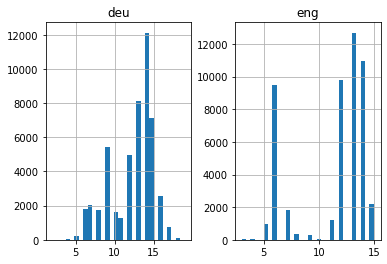

In [ ]:
# empty lists
eng_l = []
fr_l = []

# populate the lists with sentence lengths
for i in fr_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fr_eng[:,1]:
      fr_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fr':fr_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(fr_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 200


In [ ]:
# prepare French tokenizer
fr_tokenizer = tokenization(fr_eng[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 8
print('French Vocabulary Size: %d' % fr_vocab_size)

French Vocabulary Size: 335


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fr_eng, test_size=0.2, random_state = 12)

In [ ]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
# model compilation
model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)

W0707 15:35:08.328547 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 15:35:08.386884 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 15:35:08.403925 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 15:35:09.492994 140575117084480 deprecation.py:323] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be remov

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

W0707 15:35:10.527502 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 15:35:10.536232 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [ ]:
filename = 'model.h1.15_07_2020'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

W0707 15:35:12.633531 140575117084480 deprecation_wrapper.py:119] From /home/alain/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 71s 2ms/step - loss: 3.0174 - val_loss: 2.3031

Epoch 00001: val_loss improved from inf to 2.30307, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 69s 2ms/step - loss: 1.9510 - val_loss: 1.6549

Epoch 00002: val_loss improved from 2.30307 to 1.65492, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 77s 2ms/step - loss: 1.5582 - val_loss: 1.4758

Epoch 00003: val_loss improved from 1.65492 to 1.47575, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 88s 3ms/step - loss: 1.2989 - val_loss: 1.1194

Epoch 00004: val_loss improved from 1.47575 to 1.11938, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 91s 3ms/step - loss: 1.1167 - val_loss: 1.1408

Epoch 00005: val_loss did not improve from 1.11938
Epoch 6/30

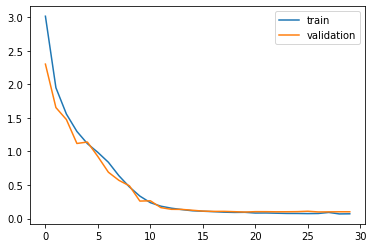

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
preds

array([[43,  7,  3, ..., 68,  2, 33],
       [35,  6,  3, ..., 57,  2, 54],
       [54,  6,  3, ..., 52,  2, 33],
       ...,
       [61,  7,  3, ..., 58,  2, 43],
       [94, 92, 80, ..., 75,  0,  0],
       [13,  6,  5, ..., 30, 14, 15]])

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
preds_text

['april and it is sometimes mild in june',
 'fall but it is never pleasant in march',
 'march but it is sometimes rainy in june',
 'during spring but it is mild in august',
 'during february and it is rainy in november',
 'may but it is sometimes pleasant in autumn',
 'bananas are his most loved fruit  ',
 'during spring and it is beautiful in april',
 'favorite fruit but the apple is our favorite',
 'my favorite animal was the lion  ',
 'april but it is never chilly in winter',
 'during february and it is pleasant in september',
 'winter but it is never mild in january',
 'during spring and it is rainy in april',
 'during winter and it is chilly in fall',
 'february but it is sometimes mild in summer',
 'august and it is usually quiet in spring',
 'fruit but the mango is your most loved',
 'april and it is usually relaxing in fall',
 'he likes limes pears and lemons  ',
 'march and it is sometimes dry in winter',
 'winter and it is never warm in november',
 'fruit but the grapefruit i

In [ ]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'actual' : test[:,0]})

In [ ]:
# print 15 rows randomly
pred_df.sample(15)

,predicted,actual
7549,may but it is usually hot in spring,paris is sometimes busy during may but it is usually warm in spring \n
9669,he likes pears mangoes and lemons,she likes pears mangoes and lemons \n
8311,january and it is usually mild in november,france is sometimes busy during january and it is usually mild in november \n
5060,november but it is never freezing in summer,paris is wet during november but it is never freezing in summer \n
3351,she dislikes bananas mangoes and apples,she dislikes mangoes bananas and apples\n
9264,they dislike grapes lemons and bananas,you dislike grapes lemons and bananas \n
5529,favorite fruit but the lemon is their favorite,the grape is our favorite fruit but the lemon is their favorite \n
9005,may but it is sometimes pleasant in autumn,india is sometimes freezing during june but it is sometimes pleasant in autumn \n
3517,november and it is usually pleasant in fall,china is rainy during autumn and it is usually pleasant in fall \n
4390,you dislike oranges grapes and grapefruit,they dislike oranges grapes and grapefruit \n


In [ ]:
def Average(lst): 
    return sum(lst) / len(lst)
pred_df

,predicted,actual
0,april and it is sometimes mild in june,the united states is busy during april and it is sometimes mild in june \n
1,fall but it is never pleasant in march,china is never hot during fall but it is never nice in march \n
2,march but it is sometimes rainy in june,new jersey is sometimes wonderful during march but it is sometimes rainy in june \n
3,during spring but it is mild in august,paris is never relaxing during december but it is mild in august \n
4,during february and it is rainy in november,california is never busy during february and it is rainy in november \n
5,may but it is sometimes pleasant in autumn,france is never quiet during march but it is sometimes pleasant in autumn \n
6,bananas are his most loved fruit,bananas are her most loved fruit \n
7,during spring and it is beautiful in april,france is wonderful during spring and it is beautiful in april \n
8,favorite fruit but the apple is our favorite,the mango is his favorite fruit but the apple is our favorite \n
9,my favorite animal was the lion,my favorite animal was the lion \n
